# Projet MADMC

In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import NDTree

In [2]:
def readInstance(path):

    with open(path, 'r') as f:
        allLines = f.readlines()

    n = int(allLines[2].split(" ")[1])

    objects = np.empty((n, 3))
    for i, line in enumerate(allLines[4:4+n]):
        objects[i] = list( map(int, line.rstrip().lstrip("i ").split("\t")) )

    W = int(allLines[-2].split(" ")[1])

    return objects, W

In [3]:
def readNotDominatedPoints(path):

    with open(path, 'r') as f:
        allLines = f.readlines()

    allPoints = []
    for line in allLines:
        allPoints.append( list(map(int, line.rstrip().split("\t"))) )

    return np.array(allPoints)

In [4]:
def proportionNotDominated(nd_points, potential_nd_points):
    nd_points_set = set(list(map(tuple, nd_points)))
    potential_nd_points_set = set(list(map(tuple, potential_nd_points)))
    
    return len(nd_points_set & potential_nd_points_set)/len(nd_points)

In [5]:
def averageDistance(nd_points, potential_nd_points):
    nadir_pt = np.array((nd_points[:, 0].min(), nd_points[:, 1].min()))
    print(nadir_pt)
    ideal_pt = np.array((nd_points[:, 0].max(), nd_points[:, 1].max()))
    p1 = 1/(ideal_pt[0]-nadir_pt[0])
    p2 = 1/(ideal_pt[1]-nadir_pt[1])
    
    distances = []
    
    for i, nd_point in enumerate(nd_points):
        euclidian_dist = math.inf
        for potential_nd_point in potential_nd_points:
            euclidian_dist_tmp =  math.sqrt(p1*(potential_nd_point[0]-nd_point[0])**2 + p2*(potential_nd_point[1]-nd_point[1])**2)
            
            if(euclidian_dist_tmp < euclidian_dist):
                euclidian_dist = euclidian_dist_tmp
    
        distances.append(euclidian_dist)
    
    distances = np.array(distances)
    
    return (1/len(nd_points))*distances.sum()


In [6]:
def solutionTotalWeight(solution, objects):
    sum = 0
    for i, sol in enumerate(solution):
        if(sol == 1):
            sum += objects[:,0][i]
    return sum

In [7]:
def generatePop(objects, max_weight):
    solution = np.random.randint(2, size=len(objects))
    sumWeights = 0
    freeObjectsIndexes = []
    
    for i in range(0, len(solution)):
        if(solution[i] == 1):
            sumWeights += objects[:,0][i]
        else:
            freeObjectsIndexes.append(i)

        #make sure that the solution respects max weight
        if(sumWeights > max_weight):
            solution[i] = 0
            sumWeights -= objects[:,0][i]
            freeObjectsIndexes.append(i)
    
    #add random objects to fill the bag
    while(sumWeights < max_weight and len(freeObjectsIndexes) > 0):
        i = random.randint(0, len(freeObjectsIndexes)-1)
        if(sumWeights + objects[:,0][freeObjectsIndexes[i]] < max_weight):
            solution[freeObjectsIndexes[i]] = 1
            sumWeights += objects[:,0][freeObjectsIndexes[i]]
            #print("add ", objects[:,0][freeObjectsIndexes[i]], sumWeights)
        del freeObjectsIndexes[i]
            
    #print("current weight : ", sumWeights, " max weight : ", max_weight)
    
    
    return solution

In [8]:
def neighborhood(solution, objects, max_weight):
    solutionSum = solution.sum()
    neighborhoodPop = []
    
    #if there is at least one object selected and still some other(s) not selected
    if(solutionSum >= 1 and solutionSum < len(objects)):
        totalWeight = solutionTotalWeight(solution, objects)
        newTotalWeight = totalWeight
        neighbor_sol = solution.copy()
        permutationDone = False
        
        #sort objects in two lists (of indexes) wether they are in backpack or not
        availableObjects = []
        takenObjects = []
        for i in range(0, len(neighbor_sol)-1):
            if(neighbor_sol[i] == 0):
                availableObjects.append(i)
            else:
                takenObjects.append(i)
                
        for i in range(len(takenObjects)):
            takenObjectIndex = takenObjects[i]

            for j in range(len(availableObjects)):
                availableObjectIndex = availableObjects[j]

                newTotalWeight = totalWeight - objects[:,0][takenObjectIndex] + objects[:,0][availableObjectIndex]

                #permutation only if valid solution
                if(newTotalWeight > max_weight):
                    break
                else:
                    neighbor_sol = solution.copy()
                    totalWeight = newTotalWeight
                    permutationDone = True
                    neighbor_sol[takenObjectIndex] = 0
                    neighbor_sol[availableObjectIndex] = 1
                    
                    availableObjectsTmp = availableObjects.copy()
                    availableObjectsTmp.append(availableObjectIndex)
                    del availableObjectsTmp[j] #no need to del for takenObjects (list not used after)
                    #print("replaced index", takenObjectIndex, "with", availableObjectIndex)


                    #new spaces filled with objects if possible
                    new_object_index = random.randint(0, len(availableObjectsTmp)-1)
                    availableObjectIndex = availableObjectsTmp[new_object_index]

                    while(totalWeight < max_weight and len(availableObjectsTmp) > 0):
                        if(totalWeight+objects[:,0][availableObjectIndex] <= max_weight):
                            neighbor_sol[availableObjectIndex] = 1
                            totalWeight += objects[:,0][availableObjectIndex]

                        del availableObjectsTmp[new_object_index]

                        if(len(availableObjectsTmp) > 0): #verification for the last loop
                            new_object_index = random.randint(0, len(availableObjectsTmp)-1)
                            availableObjectIndex = availableObjectsTmp[new_object_index]
                    
                    neighborhoodPop.append(neighbor_sol)
                    
        #print("aa",neighborhoodPop,"bb", neighborhoodPop[0])
        return neighborhoodPop

In [9]:
def evaluateSolution(solution, earnings):
    earnings_values = [0]*(earnings[0].size)
    
    for i in range(earnings[0].size): #for each objective
        for j in range(earnings[:, i].size-1): #the valuation for each object
            earnings_values[i] += solution[j]*earnings[:, i][j] #solution[j] = 1 or 0
    return earnings_values

In [10]:
def evaluate_solution(solution, objects, capacity, with_capacity=False):
    evaluation = np.matmul(solution.T, objects)

    # retourne solution + sa validité
    if with_capacity:
        return evaluation[0] <= capacity, evaluation
    else:
        return evaluation[0] <= capacity, evaluation[1:]



In [11]:
def isDominated(sol1, sol2, earnings):
    earnings_sol1 = evaluateSolution(sol1, earnings)
    earnings_sol2 = evaluateSolution(sol2, earnings)
    if earnings_sol1[0] < earnings_sol2[0]:
        return earnings_sol1[1] <= earnings_sol2[1]
    return False

In [12]:
def update(solutionsSet, solutionToReview, objects, earnings):

    update = True
    for solution in reversed(solutionsSet):
        if(isDominated(solutionToReview, solution, earnings)):
            update = False
            break
        #if(isDominated(solution, solutionToReview, earnings)):#si la nouvelle solution domine un point
            #solutionsSet.remove(solution)
        #print(solution)

    #remove the dominated points by the new solution
    if update:
        solutionsSet.append(np.array(solutionToReview))
    return update

In [13]:
def arraytoString(array):
    return ''.join(array)


In [14]:
def plot_objective_space(points, points2):
    x, y = [i[0] for i in points], [j[1] for j in points]
    x2, y2 = [int(i[0]) for i in points2], [int(j[1]) for j in points2]
    plt.scatter(x, y, c='red')
    plt.scatter(x2, y2, c='blue')
    plt.show()

In [72]:
def localParetoSearch1(objects, capacity, non_dominated_points=[]):
    earnings = objects[:, 1:]

    #objects = objects[objects[:, 0].argsort()]

    #random_sol, solution_alea = generatePop(objects, capacity)
    random_sol = generatePop(objects, capacity)

    #valid, evalP = evaluateSolution(solution_alea, objects, capacity)
    evalP = evaluateSolution(random_sol, objects, capacity)
    
    # initialisation d'un ens. de sol. efficaces  et d'une population
    population = []
    efficient_solutions = []
    efficient_solutions.append(random_sol)
    population= np.array(random_sol)
    k = 0
    ez = [evalP]
    # initialisation d'une pop. auxiliaire
    auxiliar_population = []
    evalBase = []
    while(len(population) > 0):
        k += 1
        j = 0

        #print(population)
        # génération de tous les voisins de chaque solution appartenant à population
        nghbhood, evals = [], []
        for p in population:
            print(str((j)/len(population)*100) + '%')

            j += 1

            valid, evalBase = evaluate_solution(p, objects, capacity)
            #evalBase = evaluateSolution(p, earnings)


            #voisinage, evals = voisinage1_1(p, objects, capacity)
            nghbhood = neighborhood(p, objects, capacity)
            
            #while not voisinage:
            #voisinage, evals = voisinage1_1(p, objects, capacity)

            #for voisin, eval in zip(voisinage, evals):
            for neighbor in nghbhood:
                #print('nouvelleeval')
                #print(eval)
                # si p_prime n'est pas dominé par p:

                #if not dominated(eval, evalBase):
                if not Dominates(neighbor, p):

                    if update(auxiliar_population, neighbor, objects, earnings):
                        update(efficient_solutions, neighbor, objects, earnings)
                        
            nghbhood, evals = [], []
            
            
        if len(efficient_solutions) > 10:
            ez = [evaluateSolution(r, earnings) for r in efficient_solutions]
            print(ez)
            plot_objective_space(ez, non_dominated_points)

        population = auxiliar_population
        auxiliar_population = []
        #print('efficient solutions=Evaluations')
        print('taille du front efficace')
        print(np.array(efficient_solutions).shape)

    return efficient_solutions


In [141]:
def localParetoSearchNew(objects, capacity, non_dominated_points = []):
    earnings = objects[:, 1:]
    weights = objects[:, 0]
    nbDims = 2
    #NDTree.NDTree(nbDims)
    #objects = objects[objects[:, 0].argsort()]

    #random_sol, solution_alea = generatePop(objects, capacity)
    random_sol = generatePop(objects, capacity)
    
    #valid, evalP = evaluateSolution(solution_alea, objects, capacity)
    valid,evalP = evaluate_solution(random_sol,objects, capacity)
    
    # initialisation d'un ens. de sol. efficaces  et d'une population
    population = []
    initial_solution = {tuple(random_sol): np.array(evalP)}
    efficient_solutions = NDTree.NDTree(nbDims)
    efficient_solutions.Update(initial_solution)
    population.append(random_sol)
    k = 0
    ez = []
    ez.append(evalP)
    # initialisation d'une pop. auxiliaire
    auxiliar_population = NDTree.NDTree(nbDims)
    auxiliar_population = []
    evalBase = []
    while(len(population) > 0):
        k += 1
        j = 0

        #print(population)
        # génération de tous les voisins de chaque solution appartenant à population
        nghbhood, evals = [], []
        for p in population:
            #print(str((j)/len(population)*100) + '%')

            j += 1

            #valid, evalBase = evaluate_solution(p, objects, capacity)
            valid2 ,evalBase = evaluate_solution(p,objects, capacity)


            #voisinage, evals = voisinage1_1(p, objects, capacity)
            nghbhood = neighborhood(p, objects, capacity)
            
            #while not voisinage:
            #voisinage, evals = voisinage1_1(p, objects, capacity)

            #for voisin, eval in zip(voisinage, evals):
            for neighbor in nghbhood:
                
                #print('nouvelleeval')
                #print(eval)
                # si p_prime n'est pas dominé par p:
                valid3, evalNeighbor = evaluate_solution(neighbor,objects, capacity)
                #if not dominated(eval, evalBase):
                if not Dominates(evalBase, evalNeighbor) and valid3 and valid2:
                    candidate = {tuple(neighbor): np.array(evalNeighbor)}

                    if update(auxiliar_population, neighbor, objects, earnings):
                        efficient_solutions.Update(candidate)
                        
            nghbhood, evals = [], []
            
        eff = []    
        if efficient_solutions.getSize() > 1:
            eff = efficient_solutions.getPoints().values()
            #ez = [evaluate_solution(r, objects,capacity)[1] for r in eff]
            
            #print(ez)


            plot_objective_space(eff, non_dominated_points)
        population = auxiliar_population
        
        auxiliar_population = []

        #print('efficient solutions=Evaluations')
        print('taille du front efficace')
        print(len(eff))

    return efficient_solutions


In [60]:
a = []
b = np.array([4,5,6])
a.append(b)
a.remove(b)
print(a)

[]


**-------------TEST METHODES-------------**

In [18]:
(objects, weight) = readInstance("100_items/2KP100-TA-0.dat")
nd_points = readNotDominatedPoints("100_items/2KP100-TA-0.eff")
print(objects, "\n max weight :", weight)

[[394. 783. 840.]
 [911. 198. 798.]
 [768. 278. 335.]
 [477. 629. 554.]
 [513. 952. 365.]
 [636. 717. 916.]
 [607.  17. 142.]
 [138. 804. 243.]
 [401. 130. 157.]
 [998. 219. 109.]
 [839. 613. 513.]
 [637. 524. 296.]
 [972. 293. 494.]
 [527. 770. 771.]
 [891. 284. 400.]
 [807. 919. 353.]
 [949. 526.  70.]
 [193. 663.  86.]
 [349.  65. 890.]
 [458.  64.  21.]
 [970. 902. 239.]
 [267. 540. 851.]
 [760. 513. 375.]
 [532.  40. 668.]
 [931. 930. 438.]
 [285. 738. 721.]
 [354. 688. 640.]
 [440. 880. 166.]
 [331. 229. 829.]
 [351. 686. 893.]
 [589. 657. 956.]
 [440. 924. 858.]
 [814. 684. 399.]
 [483. 216. 911.]
 [920. 148. 950.]
 [641. 432. 881.]
 [281. 786. 619.]
 [447. 226. 308.]
 [276. 556. 188.]
 [170. 906. 417.]
 [126. 495. 104.]
 [984. 935. 760.]
 [383. 750. 684.]
 [294. 233. 369.]
 [245. 153. 584.]
 [126. 793. 732.]
 [745.  75. 164.]
 [ 53. 522. 950.]
 [240. 798. 177.]
 [656. 967. 732.]
 [759.  94. 639.]
 [520.  79. 135.]
 [205. 461.  70.]
 [573. 755. 819.]
 [158. 999.  52.]
 [890. 126

In [19]:
#earnings for each objective
earnings = objects[:,1:]
print(earnings[:, 1].size-1)
print(earnings)

99
[[783. 840.]
 [198. 798.]
 [278. 335.]
 [629. 554.]
 [952. 365.]
 [717. 916.]
 [ 17. 142.]
 [804. 243.]
 [130. 157.]
 [219. 109.]
 [613. 513.]
 [524. 296.]
 [293. 494.]
 [770. 771.]
 [284. 400.]
 [919. 353.]
 [526.  70.]
 [663.  86.]
 [ 65. 890.]
 [ 64.  21.]
 [902. 239.]
 [540. 851.]
 [513. 375.]
 [ 40. 668.]
 [930. 438.]
 [738. 721.]
 [688. 640.]
 [880. 166.]
 [229. 829.]
 [686. 893.]
 [657. 956.]
 [924. 858.]
 [684. 399.]
 [216. 911.]
 [148. 950.]
 [432. 881.]
 [786. 619.]
 [226. 308.]
 [556. 188.]
 [906. 417.]
 [495. 104.]
 [935. 760.]
 [750. 684.]
 [233. 369.]
 [153. 584.]
 [793. 732.]
 [ 75. 164.]
 [522. 950.]
 [798. 177.]
 [967. 732.]
 [ 94. 639.]
 [ 79. 135.]
 [461.  70.]
 [755. 819.]
 [999.  52.]
 [126. 205.]
 [870. 997.]
 [923.  73.]
 [163. 594.]
 [819. 392.]
 [579. 359.]
 [100. 453.]
 [304. 531.]
 [877. 992.]
 [ 36. 748.]
 [925. 748.]
 [979. 873.]
 [983. 744.]
 [164. 667.]
 [ 77. 830.]
 [629. 650.]
 [317. 229.]
 [ 75. 329.]
 [651. 633.]
 [280. 511.]
 [114. 546.]
 [944. 47

In [20]:
#print(nd_points)
#nd_points = np.hsplit(nd_points, 2)
#print(nd_points)
#plot.plot(nd_points[:,0], nd_points[:,1])

In [21]:
generatedPop = generatePop(objects, weight)
print(generatedPop, solutionTotalWeight(generatedPop, objects), len(neighborhood(generatedPop, objects, weight)))

[1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0
 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1
 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0] 26840.0 345


In [22]:
evaluateSolution(generatedPop, earnings)

[27811.0, 27832.0]

In [154]:

def Dominates(point, candidate):
    return sum([point[x] >= candidate[x] for x in range(len(point))]) == len(point) 

import importlib
import NDTree #import the module here, so that it can be reloaded.
importlib.reload(NDTree)

<module 'NDTree' from '/home/clemspace/Bureau/M2-21-22/MADMC/ProjetMADMC2022/NDTree.py'>

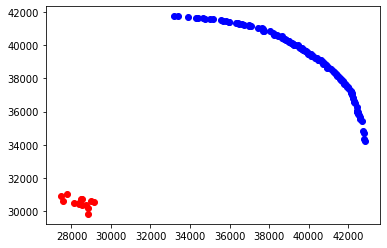

taille du front efficace
14


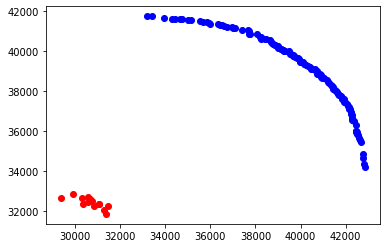

taille du front efficace
14


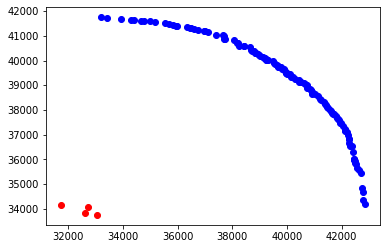

taille du front efficace
4


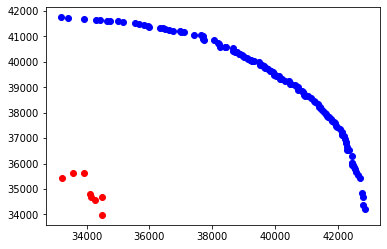

taille du front efficace
8


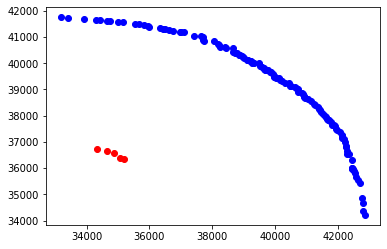

taille du front efficace
5


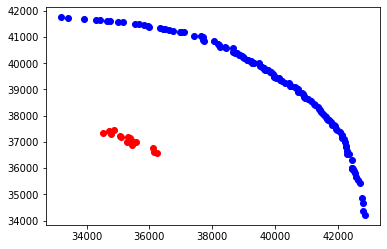

taille du front efficace
15


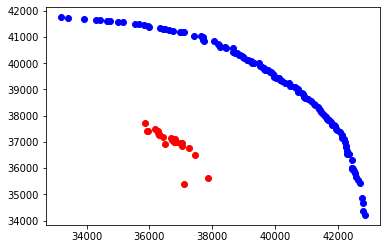

taille du front efficace
22


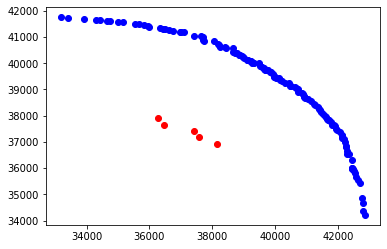

taille du front efficace
5


In [ ]:
localParetoSearchNew(objects, weight, nd_points)

In [147]:
def localParetoSearchNew2(objects, capacity, non_dominated_points = []):
    earnings = objects[:, 1:]
    weights = objects[:, 0]
    nbDims = 2
    #NDTree.NDTree(nbDims)
    #objects = objects[objects[:, 0].argsort()]

    #random_sol, solution_alea = generatePop(objects, capacity)
    random_sol = generatePop(objects, capacity)
    
    #valid, evalP = evaluateSolution(solution_alea, objects, capacity)
    valid,evalP = evaluate_solution(random_sol,objects, capacity)
    
    # initialisation d'un ens. de sol. efficaces  et d'une population
    population = []
    initial_solution = {tuple(random_sol): np.array(evalP)}
    efficient_solutions = NDTree.NDTree(nbDims)
    efficient_solutions.Update(initial_solution)
    population.append(random_sol)
    k = 0
    ez = []
    ez.append(evalP)
    # initialisation d'une pop. auxiliaire
    auxiliar_population = NDTree.NDTree(nbDims)
    evalBase = []
    while(len(population) > 0):
        k += 1
        j = 0

        #print(population)
        # génération de tous les voisins de chaque solution appartenant à population
        nghbhood, evals = [], []
        for p in population:
            #print(str((j)/len(population)*100) + '%')

            j += 1

            #valid, evalBase = evaluate_solution(p, objects, capacity)
            valid2 ,evalBase = evaluate_solution(p,objects, capacity)


            #voisinage, evals = voisinage1_1(p, objects, capacity)
            nghbhood = neighborhood(p, objects, capacity)
            
            #while not voisinage:
            #voisinage, evals = voisinage1_1(p, objects, capacity)

            #for voisin, eval in zip(voisinage, evals):
            for neighbor in nghbhood:
                
                #print('nouvelleeval')
                #print(eval)
                # si p_prime n'est pas dominé par p:
                valid3, evalNeighbor = evaluate_solution(neighbor,objects, capacity)
                #if not dominated(eval, evalBase):
                if not Dominates(evalBase, evalNeighbor) and valid3 and valid2:
                    candidate = {tuple(neighbor): np.array(evalNeighbor)}
    
                    if auxiliar_population.Update(candidate):
                        efficient_solutions.Update(candidate)
                        
            nghbhood, evals = [], []
            
        eff = []    
        if efficient_solutions.getSize() > 1:
            eff = efficient_solutions.getPoints().values()
            #ez = [evaluate_solution(r, objects,capacity)[1] for r in eff]
            
            #print(ez)


            plot_objective_space(eff, non_dominated_points)
        population = []
        for i in auxiliar_population.getSolutions():
            population.append(np.asarray(i))
        auxiliar_population = NDTree.NDTree(nbDims)
        

        #print('efficient solutions=Evaluations')
        print('taille du front efficace')
        print(len(eff))

    return efficient_solutions


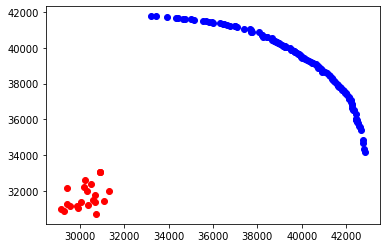

taille du front efficace
22


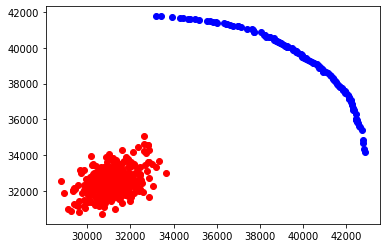

taille du front efficace
346


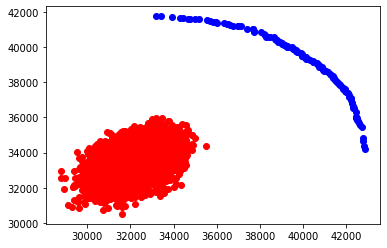

taille du front efficace
3832


KeyboardInterrupt: 

In [148]:
localParetoSearchNew2(objects, weight, nd_points)